# Train

from dataset import VCTK_Dataset, DataLoader
from train import train

import os, warnings, argparse

def parse_args(string=None):
    parser = argparse.ArgumentParser()
    parser.add_argument('--lr', default=1e-4,
                        type=float, help='leanring rate')
    parser.add_argument('--epoch', default=8,
                        type=int, help='epochs')
    parser.add_argument('--batch-size', default=64,
                        type=int, help='batch size')
    parser.add_argument('--gpu', default="0",
                        type=str, help="0:1080ti 1:1070")
    parser.add_argument('--num-workers', default=6,
                        type=int, help='dataloader num workers')
    parser.add_argument('--save-path', default='trained_model',
                        type=str, help='.pth model file save dir')
    
    args = parser.parse_args() if string is None else parser.parse_args(string)
    if not os.path.exists(args.save_path): os.makedirs(args.save_path)
    return args
    
if __name__=='__main__':
    args = parse_args('')
    
    os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu #0:1080ti 1:1070
    warnings.filterwarnings("ignore")
    
    ## load dataset
    train_dataset = VCTK_Dataset('preprocess/vctk.h5', 'preprocess/sample_segments/train_samples', seg_len=128, mode='train')
    valid_dataset = VCTK_Dataset('preprocess/vctk.h5', 'preprocess/sample_segments/valid_samples', seg_len=128, mode='test')

    train_dataloader = DataLoader(train_dataset, 
                                  batch_size=args.batch_size,
                                  #num_workers = args.num_workers,
                                  shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, 
                                  batch_size=args.batch_size*4)
                                  #num_workers = args.num_workers)
    
    ## train
    train(args, train_dataloader, valid_dataloader)

# Test

In [1]:

from model import cc, CVAE
from preprocess.tacotron.norm_utils import spectrogram2wav, get_spectrograms

import warnings, torch
import numpy as np
from scipy.io.wavfile import write

warnings.filterwarnings('ignore')


In [2]:
def result(P_s, P_t, _id):
    global spectrogram, output
    _, spectrogram = get_spectrograms(f'/media/D/DLHLP/hw2/Corpus/wav48/p{P_s}/p{P_s}_{_id}.wav')

    _input = np.expand_dims(spectrogram, axis=0)
    _input = torch.tensor(_input).permute(0,2,1).cuda()
    _person = torch.tensor([P_t-1]).cuda()

    output = autoencoder(_input, _person)

    output = output.squeeze(axis=0).transpose(1,0).cpu().detach().numpy()

    wav_data = spectrogram2wav(output)
    write(f'result/{P_s}_{P_t}_{_id}.wav', 16000, data=wav_data)
    
autoencoder = cc(CVAE())
autoencoder.load_state_dict(torch.load('trained_model/epoch_9_autoencoder_loss_0.0048.pt')['state_dict'])

testing = [{'P_s':2, 'P_t':1, '_id':338},
           {'P_s':2, 'P_t':2, '_id':338},
           {'P_s':1, 'P_t':2, '_id':334},
           {'P_s':1, 'P_t':1, '_id':334}]

for t in testing:
    result(t['P_s'], t['P_t'], t['_id'])

In [3]:
spectrogram.shape, output.shape

((350, 513), (352, 513))

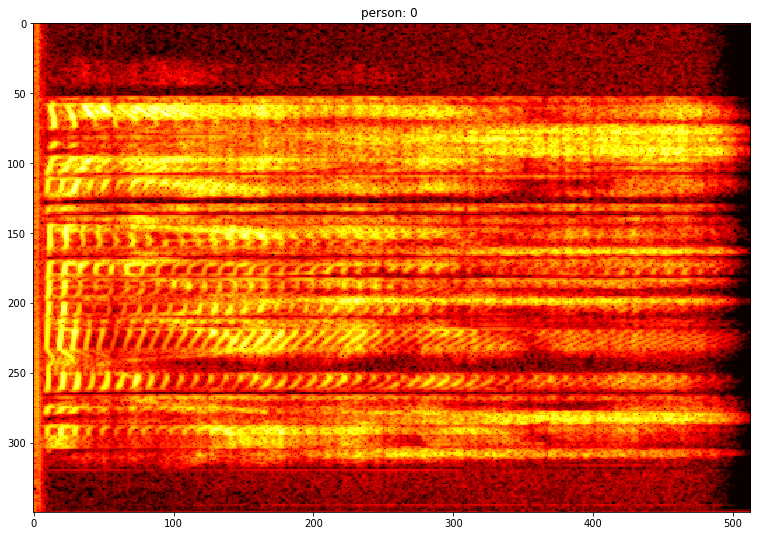

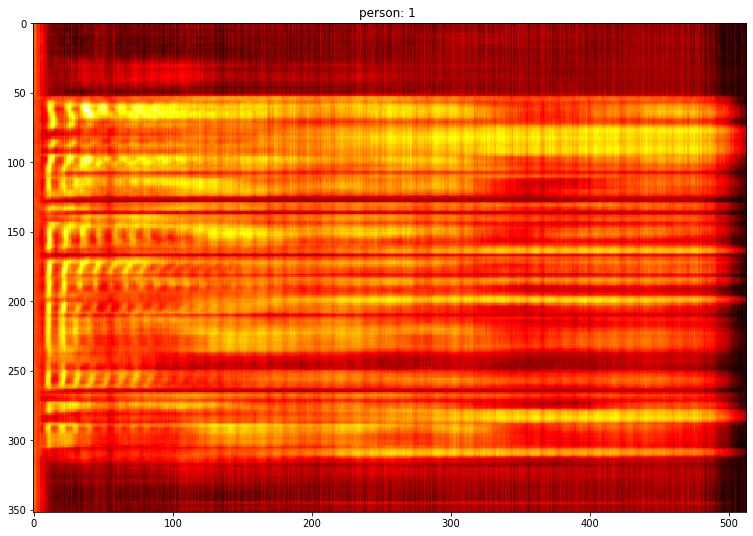

In [4]:

import matplotlib.pyplot as plt
%matplotlib inline
    
plt.figure(figsize=(16,9))
plt.title(f"person: 0 ")
plt.imshow(spectrogram, cmap="hot")
plt.show()

plt.figure(figsize=(16,9))
plt.title(f"person: 1 ")
plt.imshow(output, cmap="hot")
plt.show()


# Interpolate

In [5]:
import numpy as np

from preprocess.tacotron.norm_utils import spectrogram2wav, get_spectrograms
from scipy.io.wavfile import write


In [6]:
def interpolate(P_s, P_t, _id):
    _, spectrogram = get_spectrograms(f'/media/D/DLHLP/hw2/Corpus/wav48/p{P_s}/p{P_s}_{_id}.wav')

    _input = np.expand_dims(spectrogram, axis=0)
    _input = torch.tensor(_input).permute(0,2,1).cuda()

    p1 = torch.tensor([0]).cuda()
    p2 = torch.tensor([1]).cuda()

    output = autoencoder.interpolate(_input, p1, p2)

    output = output.squeeze(axis=0).transpose(1,0).cpu().detach().numpy()

    wav_data = spectrogram2wav(output)
    write(f'result/{P_s}_{P_t}_{_id}_interpolate.wav', 16000, data=wav_data)

testing = [{'P_s':2, 'P_t':1, '_id':338},
           {'P_s':1, 'P_t':2, '_id':334}]
for t in testing:
    interpolate(t['P_s'], t['P_t'], t['_id'])